# Results
---
This notebook contains all tools to reconstruct results presented in the article: *G. Czelusta, J. Mielczarek, **Quantum circuits for the Ising spin networks***.

In this notebook we use simulators with statistical noise coming from finite number of shots.

All names used in this notebook are the same as in the  article and all references are refrences to the article.

More explanation about our attempt can be found in ```tutorial.ipynb``` notebook. Here we just put functions used in our work.

In [1]:
# for simulation quantum circuits
import pennylane as qml
from pennylane import numpy as np

# for plotting graphs
import matplotlib.pyplot as plt

# for saving and loading data
import pandas as pd

# for multiprocessing
from multiprocessing import Pool

In [2]:
def save_params(params, file_name):
    '''Save params of SimplifiedTwoDesign ansatz to file'''
    temp = [params[0]]
    for layer in params[1]:
        temp.append(np.append(layer[:,0],np.nan))
        temp.append(np.concatenate([[np.nan],layer[:,1]]))
    pd.DataFrame(np.transpose(temp)).to_csv(file_name, index=False)

In [3]:
def load_params(file_name):
    '''Load params of SimplifiedTwoDesign ansatz from file'''
    data = pd.read_csv(file_name)
    temp = []
    for col in data:
        vals = data[col].values
        temp.append(vals[~np.isnan(vals)])
    temp2 = []
    for i in range((len(temp)-1)//2):
        temp2.append(np.transpose(temp[1+2*i:1+2*i+2]))
    return [temp[0],np.array(temp2)]

In [4]:
def W(wires):
    qml.PauliX(wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.PauliX(wires=wires[1])
    qml.CRY(2*np.arccos(1/np.sqrt(3)), wires=[wires[1],wires[0]])
    qml.PauliX(wires=wires[1])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.Hadamard(wires=wires[0])
    qml.T(wires=wires[0])
    qml.adjoint(qml.T)(wires=wires[1])
    qml.CNOT(wires=[wires[1],wires[0]])
    qml.adjoint(qml.T)(wires=wires[0])
    qml.Hadamard(wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.T(wires=wires[0])
    qml.adjoint(qml.T)(wires=wires[1])
    qml.CNOT(wires=[wires[0],wires[2]])
    qml.CNOT(wires=[wires[1],wires[3]])
    qml.Hadamard(wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.Hadamard(wires=wires[2])
    qml.CNOT(wires=[wires[2],wires[3]])

In [5]:
def link(wires):
    qml.PauliX(wires=wires[0])
    qml.PauliX(wires=wires[1])
    qml.Hadamard(wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])

## Dipole

In [36]:
dev8 = qml.device('lightning.qubit', wires=8, shots=20000)

In [37]:
@qml.qnode(dev8, diff_method="parameter-shift")
def cost_circ(initial_layer_weights, weights):
    link([0,4])
    link([1,5])
    link([2,6])
    link([3,7])

    qml.adjoint(W)([0,1,2,3])
    qml.adjoint(W)([4,5,6,7])

    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,4])
        
    return qml.probs(wires=range(8))

In [39]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'08b')
        if k[1:4]=='000' and k[5:8]=='000':
            c[k[0]+k[4]] = probs[i]
    return c['00']/np.sum(list(c.values()))

In [40]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

In [41]:
def foo(params):
    max_iterations = 100

    opt = qml.AdamOptimizer(stepsize=0.1)
    
    conv_tol = 1e-06

    cost = 0

    costs=[]
    paramses = []
    paramses.append(params)


    for n in range(max_iterations):
        params, prev_cost = opt.step_and_cost(cost_fn, *params)
        conv = np.abs(cost - prev_cost)
        cost=prev_cost
        costs.append(cost)
        paramses.append(params)
        
        if conv <= conv_tol:
            break
        
    return costs, paramses

In [42]:
initial_params_list = [[np.random.rand(2)*2*np.pi, np.random.rand(1,1,2)*2*np.pi] for i in range(10)]

In [43]:
costs_all=[]
params_all = []
with Pool() as pool:
    result = pool.imap_unordered(foo, initial_params_list)
    for costs, params in result:
        costs_all.append(costs)
        params_all.append(params)

In [44]:
# pd.DataFrame(costs_all).to_csv('cost_history_dipole.csv', index=False)

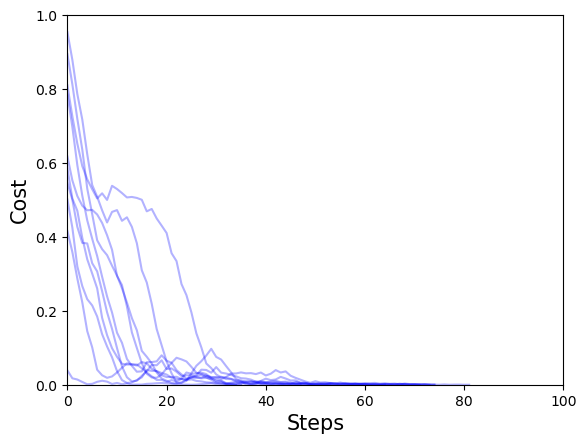

In [45]:
for costs in pd.read_csv('cost_history_dipole.csv').to_numpy():
    plt.plot(costs, color='blue', alpha=0.3)
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.ylim(0,1)
plt.xlim(0,100)
# plt.savefig('Dipole.png')

In [50]:
def fidelity(params):
    @qml.qnode(qml.device('default.qubit', wires=2))
    def dipole(optimized_params):
        qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=[0,1])
        return qml.state()

    dipole_exact = [1/np.sqrt(2),0,0,1/np.sqrt(2)]

    return np.abs(np.dot(dipole(params), dipole_exact))

In [51]:
# for i in range(10):
#     save_params(params_all[i][-1],'params_last_dipole/'+str(i)+'.csv')

In [52]:
# for i in range(10):
#     save_params(params_all[i][np.argmin(costs_all[i])],'params_best_dipole/'+str(i)+'.csv')

In [53]:
fidelities_last = []
for i in range(10):
    params=load_params('params_last_dipole/'+str(i)+'.csv')
    fidelities_last.append(fidelity(params))

print('Fidelities:')
print('Mean: ',np.mean(fidelities_last), 'std: ',np.std(fidelities_last))

Fidelities:
Mean:  0.9997880761468826 std:  0.00018328102373286613


In [54]:
fidelities_best = []
for i in range(10):
    params=load_params('params_best_dipole/'+str(i)+'.csv')
    fidelities_best.append(fidelity(params))

print('Fidelities:')
print('Mean: ',np.mean(fidelities_best), 'std: ',np.std(fidelities_best))

Fidelities:
Mean:  0.9996035544784967 std:  0.00028700793404050514


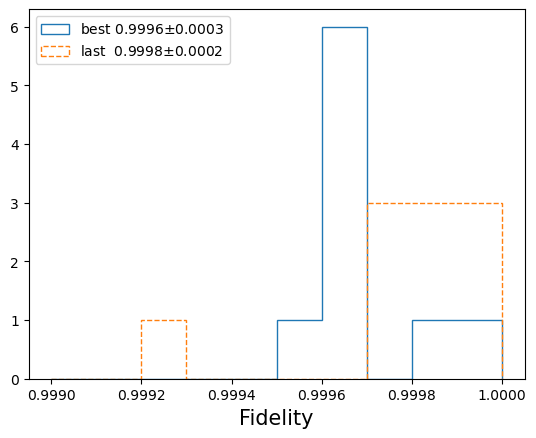

In [56]:
plt.hist(fidelities_best, histtype='step', label='best '+f'{np.mean(fidelities_best):.4f}'+'$\pm$'+f'{np.std(fidelities_best):.4f}',range=(0.999,1))
plt.hist(fidelities_last, histtype='step', label='last  '+f'{np.mean(fidelities_last):.4f}'+'$\pm$'+f'{np.std(fidelities_last):.4f}',range=(0.999,1),linestyle='dashed')
plt.xlabel('Fidelity', fontsize=15)
plt.legend(loc='upper left')
# plt.savefig('hist_dipole.png')

## Single node

In [71]:
dev8exact = qml.device('lightning.qubit', wires=8)

In [72]:
@qml.qnode(dev8exact)
def cost_circ(initial_layer_weights, weights):
    link([0,4])
    link([1,5])
    link([2,6])
    link([3,7])

    qml.adjoint(W)([0,1,2,3])
    
    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,4,5,6,7])
        
    return qml.probs(wires=range(8))

In [73]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'08b')
        if k[1:4]=='000':
            c[k[0]+k[4:]] = probs[i]
    return c['00000']/np.sum(list(c.values()))

In [74]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

In [78]:
def foo(params):
    max_iterations = 100

    opt = qml.AdamOptimizer(stepsize=0.1)
    
    conv_tol = 1e-06

    cost = 0

    costs=[]
    paramses = []
    paramses.append(params)


    for n in range(max_iterations):
        params, prev_cost = opt.step_and_cost(cost_fn, *params)
        conv = np.abs(cost - prev_cost)
        cost=prev_cost
        costs.append(cost)
        paramses.append(params)
        
        if conv <= conv_tol:
            break
        if n % 1 == 0:
            print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))
        
    return costs, paramses

In [79]:
initial_params_list = [[np.random.rand(5)*2*np.pi, np.random.rand(4,4,2)*2*np.pi] for i in range(10)]

In [126]:
costs_all=[]
params_all = []
with Pool() as pool:
    result = pool.imap_unordered(foo, initial_params_list)
    for costs, params in result:
        costs_all.append(costs)
        params_all.append(params)

In [127]:
# pd.DataFrame(costs_all).to_csv('cost_history_node.csv', index=False)

(0.0, 100.0)

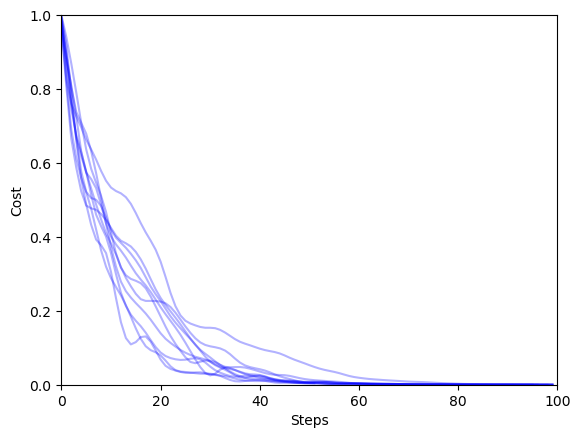

In [128]:
for costs in pd.read_csv('cost_history_node.csv').to_numpy():
    plt.plot(costs, color='blue', alpha=0.3)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.ylim(0,1)
plt.xlim(0,100)
# plt.savefig('Dipole_noise_free.png')

In [12]:
def fidelity(params):
    @qml.qnode(qml.device('default.qubit', wires=5))
    def node(optimized_params):
        qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=range(5))
        return qml.state()

    node_exact = [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.35355339, -0.35355339,  0.        ,  0.        , -0.35355339,
        0.35355339,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.40824829,
        0.        , -0.20412414, -0.20412414,  0.        ,  0.        ,
       -0.20412414, -0.20412414,  0.        ,  0.40824829,  0.        ,
        0.        ,  0.        ]

    return np.abs(np.dot(node(params), node_exact))

In [133]:
# for i in range(10):
#     save_params(params_all[i][-1],'params_last_node/'+str(i)+'.csv')

In [139]:
# for i in range(10):
#     save_params(params_all[i][np.argmin(costs_all[i])],'params_best_node/'+str(i)+'.csv')

In [17]:
fidelities_last = []
for i in range(10):
    params=load_params('params_last_node/'+str(i)+'.csv')
    fidelities_last.append(fidelity(params))

print('Fidelities:')
print('Mean: ',np.mean(fidelities_last), 'std: ',np.std(fidelities_last))

Fidelities:
Mean:  0.9997820215873066 std:  0.0005380403759697192


In [13]:
fidelities_best = []
for i in range(10):
    params=load_params('params_best_node/'+str(i)+'.csv')
    fidelities_best.append(fidelity(params))

print('Fidelities:')
print('Mean: ',np.mean(fidelities_best), 'std: ',np.std(fidelities_best))

Fidelities:


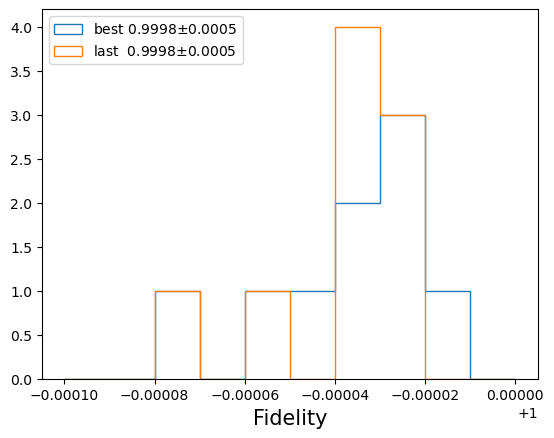

In [19]:
plt.hist(fidelities_best, histtype='step', label='best '+f'{np.mean(fidelities_best):.4f}'+'$\pm$'+f'{np.std(fidelities_best):.4f}',range=(0.9999,1))
plt.hist(fidelities_last, histtype='step', label='last  '+f'{np.mean(fidelities_last):.4f}'+'$\pm$'+f'{np.std(fidelities_last):.4f}',range=(0.9999,1))
plt.xlabel('Fidelity', fontsize=15)
plt.legend(loc='upper left')
# plt.savefig('hist_node.png')

In [14]:
best_node = load_params('params_best_node/'+str(np.argmax(fidelities_best))+'.csv')

## Pentagram

In [159]:
dev17 = qml.device('default.qubit', wires=17, shots=200000)

In [160]:
pentagram_links = [[2,6],[3,10],[4,14],[7,11],[8,15],[12,16]]

In [165]:
@qml.qnode(dev17, diff_method='parameter-shift')
def cost_circ(initial_layer_weights, weights):
        
    qml.adjoint(qml.SimplifiedTwoDesign)(best_node[0],best_node[1],wires=[0,1,5,9,13])

    for l in pentagram_links:
        link(l)

    qml.adjoint(W)([1,2,3,4])
    qml.adjoint(W)([5,6,7,8])
    qml.adjoint(W)([9,10,11,12])
    qml.adjoint(W)([13,14,15,16])

    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,1,5,9,13])
        
    return qml.probs(wires=range(17))

In [166]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'017b')
        if k[2:5]=='000' and k[6:9]=='000' and k[10:13]=='000' and k[14:17]=='000':
            c[k[0]+k[1]+k[5]+k[9]+k[13]] = probs[i]
    if np.sum(list(c.values()))==0:
        return 0
    else:
        return c['00000']/np.sum(list(c.values()))

In [167]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

In [169]:
def foo(params):
    opt = qml.AdamOptimizer(stepsize=0.1)

    max_iterations = 100
    conv_tol = 1e-06

    cost = 0
    
    costs=[]
    paramses = []
    paramses.append(params)

    for n in range(max_iterations):
        params, prev_cost = opt.step_and_cost(cost_fn, *params)
        conv = np.abs(cost - prev_cost)
        cost=prev_cost
        costs.append(cost)
        paramses.append(params)
        
        if conv <= conv_tol:
            break

        if n % 1 == 0:
            print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))
        
    return costs, paramses

In [170]:
initial_params_list = [[np.random.rand(5)*2*np.pi, np.random.rand(4,4,2)*2*np.pi] for i in range(10)]

In [30]:
costses=[]
params_last = []
with Pool() as pool:
    result = pool.imap_unordered(foo, initial_params_list)
    for costs, params in result:
        costses.append(costs)
        params_last.append(params)

In [39]:
# pd.DataFrame(costses).to_csv('cost_history_pentagram.csv', index=False)

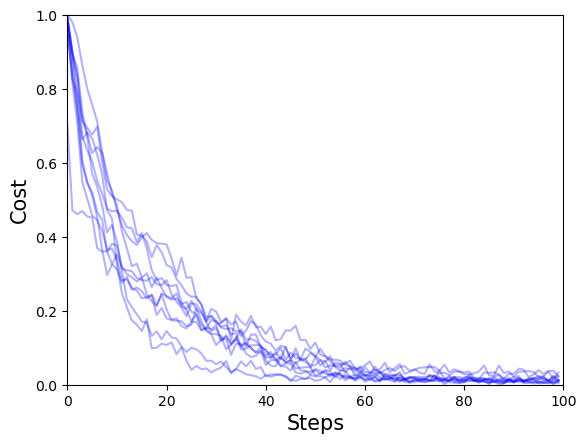

In [ ]:
for costs in pd.read_csv('cost_history_pentagram.csv').to_numpy():
    plt.plot(costs, color='blue', alpha=0.3)
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.ylim(0,1)
plt.xlim(0,100)
# plt.savefig('Pentagram.png')

In [49]:
# for i, params in enumerate(params_last):
#     save_params(params[-1], 'params_last_pentagram/'+str(i)+'.csv')

In [51]:
# for i, params in enumerate(params_last):
#     ind = np.argmin(costses[i])
#     save_params(params[ind], 'params_best_pentagram/'+str(i)+'.csv')

In [13]:
def fidelity(params):
    @qml.qnode(qml.device('default.qubit', wires=5))
    def pentagram(optimized_params):
        qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=[0,1,2,3,4])
        return qml.state()

    pentagram_exact = 1/np.sqrt(14)*np.array([3/2,0,0,3/2,0,0,0,0,0,0,0,0,0,-np.sqrt(3)/2,-np.sqrt(3)/2,1,0,0,0,0,0,-np.sqrt(3)/2,-np.sqrt(3)/2,-1,3/2,0,0,-1/2,0,-1,1,0])

    return np.abs(np.dot(pentagram(params), pentagram_exact))

In [ ]:
fidelities_last = []
for i in range(10):
    params = load_params('params_last_pentagram/'+str(i)+'.csv')
    fidelities_last.append(fidelity(params))

print('Fidelities:')
print('Mean: ',np.mean(fidelities_last), 'std: ',np.std(fidelities_last))

Fidelities:
Mean:  0.9920772318362803 std:  0.0025523994125464414


In [ ]:
fidelities_best = []
for i in range(10):
    params = load_params('params_best_pentagram/'+str(i)+'.csv')
    fidelities_best.append(fidelity(params))

print('Fidelities:')
print('Mean: ',np.mean(fidelities_best), 'std: ',np.std(fidelities_best))

Fidelities:
Mean:  0.9930509907081564 std:  0.003157206733664631


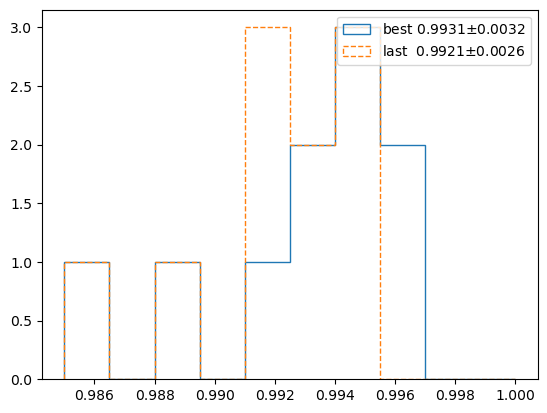

In [ ]:
plt.hist(fidelities_best, histtype='step', label='best '+f'{np.mean(fidelities_best):.4f}'+'$\pm$'+f'{np.std(fidelities_best):.4f}', range=(0.985,1))
plt.hist(fidelities_last, histtype='step', label='last  '+f'{np.mean(fidelities_last):.4f}'+'$\pm$'+f'{np.std(fidelities_last):.4f}', range=(0.985,1),linestyle='dashed')
plt.legend()
# plt.savefig('hist_pentagram.png')

## Hexagram

In [15]:
dev18 = qml.device('lightning.qubit', wires=18, shots=200000)

In [16]:
hexagram_links = [[10,14],[11,15],[12,16],[13,17]]

In [17]:
@qml.qnode(dev18, diff_method='parameter-shift')
def cost_circ(initial_layer_weights, weights):
        
    qml.adjoint(qml.SimplifiedTwoDesign)(best_node[0],best_node[1],wires=[0,1,2,3,4])
    qml.adjoint(qml.SimplifiedTwoDesign)(best_node[0],best_node[1],wires=[5,6,7,8,9])

    for l in hexagram_links:
        link(l)

    qml.adjoint(W)([1,7,10,12])
    qml.adjoint(W)([2,6,14,13])
    qml.adjoint(W)([3,9,11,17])
    qml.adjoint(W)([4,8,15,16])


    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,1,2,5,3,4])
        
    return qml.probs(wires=range(18))

In [19]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'018b')
        if (k[7]+k[10]+k[12])=='000' and (k[6]+k[14]+k[13])=='000' and (k[9]+k[11]+k[17])=='000' and (k[8]+k[15]+k[16])=='000':
            c[k[0]+k[1]+k[2]+k[5]+k[3]+k[4]] = probs[i]
    if np.sum(list(c.values()))==0:
        return 0
    else:
        return c['000000']/np.sum(list(c.values()))

In [20]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

In [43]:
def foo(params):
    opt = qml.AdamOptimizer(stepsize=0.1)

    max_iterations = 100
    conv_tol = 1e-06

    cost = 0
    
    costs=[]
    paramses = []
    paramses.append(params)

    for n in range(max_iterations):
        params, prev_cost = opt.step_and_cost(cost_fn, *params)
        conv = np.abs(cost - prev_cost)
        cost=prev_cost
        costs.append(cost)
        paramses.append(params)
        
        if conv <= conv_tol:
            break

        if n % 1 == 0:
            print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))
        
    return costs, paramses

In [66]:
initial_params_list = [[np.random.rand(6)*2*np.pi, np.random.rand(4,5,2)*2*np.pi] for i in range(6)]

In [24]:
costs_all=[]
params_all = []
with Pool() as pool:
    result = pool.imap_unordered(foo, initial_params_list)
    for costs, params in result:
        costs_all.append(costs)
        params_all.append(params)

In [70]:
# pd.DataFrame([costs]).to_csv('cost_history_hexagram.csv', index=False)

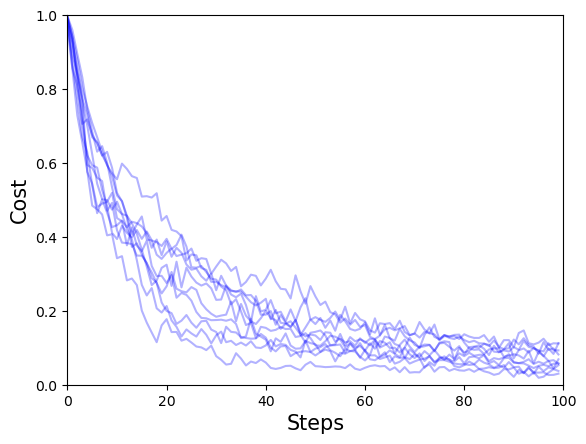

In [115]:
for cost in pd.read_csv('cost_history_hexagram.csv').to_numpy():
    plt.plot(cost, color='blue', alpha=0.3)
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.ylim(0,1)
plt.xlim(0,100)
plt.savefig('Hexagram.png')

In [72]:
# for i, params in enumerate(params_all):
#     save_params(params[-1], 'params_last_hexagram/'+str(i)+'.csv')

In [105]:
# for i, params in enumerate(params_all):
#     ind = np.argmin(pd.read_csv('cost_history_hexagram.csv').to_numpy()[0])
#     save_params(params[ind], 'params_best_hexagram/'+str(i)+'.csv')

In [106]:
def fidelity(params):
    @qml.qnode(qml.device('default.qubit', wires=6))
    def dipole(optimized_params):
        qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=[0,1,2,3,4,5])
        return qml.state()

    hexagram_exact = np.array([-2.63342585e-01,  5.65370456e-19,  1.51490340e-19, -2.63342583e-01,
        5.65370456e-19, -3.04551051e-18, -6.03377231e-20, -1.75092612e-18,
       -1.51490340e-19,  6.03377231e-20, -1.21820390e-18,  3.22994982e-18,
        6.03377231e-20,  1.52040910e-01,  1.52040910e-01,  1.75561720e-01,
       -5.65370456e-19,  1.21820425e-18,  6.03377231e-20, -1.76234378e-18,
        1.21820425e-18,  1.52040910e-01,  1.52040910e-01,  1.75561720e-01,
       -2.63342583e-01, -2.41165196e-18, -4.53151247e-19, -2.63342580e-01,
        1.84628143e-18,  1.75561720e-01,  1.75561720e-01,  2.02721212e-01,
        5.65370456e-19, -3.04551051e-18, -6.03377231e-20, -1.60958351e-18,
       -2.63342583e-01, -4.20645312e-19, -3.43688977e-18,  8.77808601e-02,
        6.03377231e-20,  1.52040910e-01,  1.52040910e-01, -1.75561720e-01,
       -3.87233526e-18,  1.75561720e-01, -1.75561720e-01,  3.45439101e-18,
        1.21820425e-18,  1.52040910e-01,  1.52040910e-01, -1.75561720e-01,
        4.20645312e-19, -1.75561720e-01,  1.75561720e-01, -2.46726461e-18,
       -1.84628143e-18, -1.75561720e-01, -1.75561720e-01,  2.02721212e-01,
        8.77808601e-02,  4.30589915e-18, -6.50422488e-18, -2.92602864e-02])
    
    return np.abs(np.dot(dipole(params), hexagram_exact))

In [107]:
fidelities_last = []
for i in range(10):
    params = load_params('params_last_hexagram/'+str(i)+'.csv')
    fidelities_last.append(fidelity(params))

print('Fidelities:')
print('Mean: ',np.mean(fidelities_last), 'std: ',np.std(fidelities_last))

Fidelities:
Mean:  0.9654695679404165 std:  0.013755252683941326


In [108]:
fidelities_best = []
for i in range(10):
    params = load_params('params_best_hexagram/'+str(i)+'.csv')
    fidelities_best.append(fidelity(params))

print('Fidelities:')
print('Mean: ',np.mean(fidelities_best), 'std: ',np.std(fidelities_best))

Fidelities:
Mean:  0.96392671413538 std:  0.014994356088559358


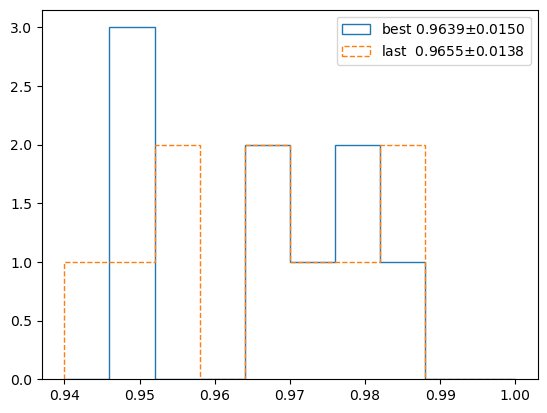

In [113]:
plt.hist(fidelities_best, histtype='step', label='best '+f'{np.mean(fidelities_best):.4f}'+'$\pm$'+f'{np.std(fidelities_best):.4f}', range=(0.94,1))
plt.hist(fidelities_last, histtype='step', label='last  '+f'{np.mean(fidelities_last):.4f}'+'$\pm$'+f'{np.std(fidelities_last):.4f}', range=(0.94,1), linestyle='dashed')
plt.legend()
plt.savefig('hist_hexagram.png')

## Open pentagram

In [12]:
dev20 = qml.device('default.qubit', wires=20)

In [13]:
pentagram_links = [[0,4],[1,8],[2,12],[3,16],[5,9],[6,13],[7,17],[10,14],[11,18],[15,19]]

In [14]:
@qml.qnode(dev20)
def cost_circ(initial_layer_weights, weights):
    for l in pentagram_links:
        link(l)

    qml.adjoint(W)([0,1,2,3])
    qml.adjoint(W)([4,5,6,7])
    qml.adjoint(W)([8,9,10,11])
    qml.adjoint(W)([12,13,14,15])

    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,4,8,12,16,17,18,19])
        
    return qml.probs(wires=range(20))

In [15]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'020b')
        if k[1:4]=='000' and k[5:8]=='000' and k[9:12]=='000' and k[13:16]=='000':
            c[k[0]+k[4]+k[8]+k[12]+k[16:]] = probs[i]
    if np.sum(list(c.values()))==0:
        return 0
    else:
        return c['00000000']/np.sum(list(c.values()))

In [16]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

In [18]:
def foo(params):
    opt = qml.AdamOptimizer(stepsize=0.1)

    max_iterations = 100
    conv_tol = 1e-06

    cost = 0
    
    costs=[]
    paramses = []
    paramses.append(params)

    for n in range(max_iterations):
        params, prev_cost = opt.step_and_cost(cost_fn, *params)
        conv = np.abs(cost - prev_cost)
        cost=prev_cost
        costs.append(cost)
        paramses.append(params)
        
        if conv <= conv_tol:
            break

        if n % 1 == 0:
            print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))
        
    return costs, paramses

In [19]:
initial_params_list = [[np.random.rand(8)*2*np.pi, np.random.rand(5,7,2)*2*np.pi] for i in range(10)]

In [20]:
costs, param_last = foo(initial_params_list[0])

Iteration = 0,  Cost = 0.99980222
Iteration = 1,  Cost = 0.98209492
Iteration = 2,  Cost = 0.93850026
Iteration = 3,  Cost = 0.89121759
Iteration = 4,  Cost = 0.84978301
Iteration = 5,  Cost = 0.81545612
Iteration = 6,  Cost = 0.76475485
Iteration = 7,  Cost = 0.71226502
Iteration = 8,  Cost = 0.67469477
Iteration = 9,  Cost = 0.64963108
Iteration = 10,  Cost = 0.63021029
Iteration = 11,  Cost = 0.61348376
Iteration = 12,  Cost = 0.59359746
Iteration = 13,  Cost = 0.56934730
Iteration = 14,  Cost = 0.54764075
Iteration = 15,  Cost = 0.53484160
Iteration = 16,  Cost = 0.52457520
Iteration = 17,  Cost = 0.50989376
Iteration = 18,  Cost = 0.49240142
Iteration = 19,  Cost = 0.47331759
Iteration = 20,  Cost = 0.45579250
Iteration = 21,  Cost = 0.44216208
Iteration = 22,  Cost = 0.42476890
Iteration = 23,  Cost = 0.39915335
Iteration = 24,  Cost = 0.37125227
Iteration = 25,  Cost = 0.34697702
Iteration = 26,  Cost = 0.32731253
Iteration = 27,  Cost = 0.30792264
Iteration = 28,  Cost = 0.2797

In [29]:
# costs_all=[]
# params_all = []
# with Pool() as pool:
#     result = pool.imap_unordered(foo, initial_params_list)
#     for costs, params in result:
#         costs_all.append(costs)
#         params_all.append(params)

(0.0, 100.0)

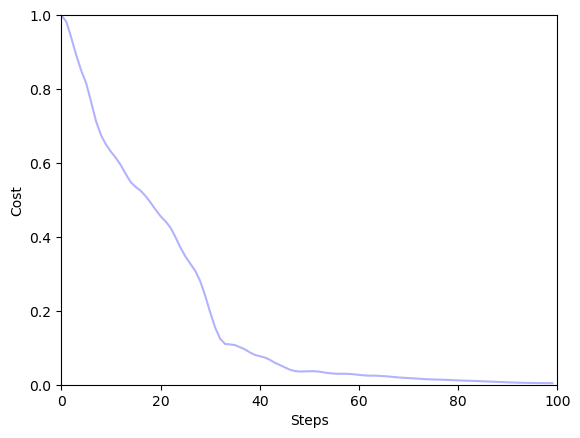

In [23]:
for cost in [costs]:
    plt.plot(cost, color='blue', alpha=0.3)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.ylim(0,1)
plt.xlim(0,100)

In [172]:
def fidelity(params):
    @qml.qnode(qml.device('default.qubit', wires=8))
    def open_pentagram(optimized_params):
        qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=range(8))
        return qml.state()

    open_pentagram_exact = np.array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.00445933e-01, -2.00445933e-01,  0.00000000e+00,
        0.00000000e+00, -2.00445933e-01,  2.00445933e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.31455027e-01,
        0.00000000e+00, -1.15727512e-01, -1.15727512e-01,  0.00000000e+00,
        0.00000000e+00, -1.15727512e-01, -1.15727512e-01,  0.00000000e+00,
        2.31455027e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.44270058e-18,  3.44270058e-18,  0.00000000e+00,
        0.00000000e+00, -3.44270058e-18, -3.44270058e-18,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.08693648e-18,
        0.00000000e+00,  1.83706729e-19, -1.83706729e-19,  0.00000000e+00,
        0.00000000e+00,  1.83706729e-19, -1.83706729e-19,  0.00000000e+00,
       -2.08693648e-18,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.44270058e-18, -3.44270058e-18,  0.00000000e+00,
        0.00000000e+00,  3.44270058e-18, -3.44270058e-18,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.70899527e-18,
        0.00000000e+00,  1.85449789e-18,  1.85449789e-18,  0.00000000e+00,
        0.00000000e+00, -1.85449789e-18, -1.85449789e-18,  0.00000000e+00,
       -3.70899527e-18,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.33630622e-01,
        0.00000000e+00,  6.68153089e-02,  6.68153089e-02,  0.00000000e+00,
        0.00000000e+00,  6.68153089e-02,  6.68153089e-02,  0.00000000e+00,
       -1.33630622e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.54303348e-01,
        0.00000000e+00, -1.92879188e-01,  3.85758360e-02,  0.00000000e+00,
        0.00000000e+00,  3.85758360e-02, -1.92879188e-01,  0.00000000e+00,
        1.54303348e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.44270058e-18, -3.44270058e-18,  0.00000000e+00,
        0.00000000e+00,  3.44270058e-18, -3.44270058e-18,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.08693648e-18,
        0.00000000e+00,  1.83706729e-19,  1.83706729e-19,  0.00000000e+00,
        0.00000000e+00, -1.83706729e-19, -1.83706729e-19,  0.00000000e+00,
        2.08693648e-18,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.33630622e-01,
        0.00000000e+00,  6.68153089e-02,  6.68153089e-02,  0.00000000e+00,
        0.00000000e+00,  6.68153089e-02,  6.68153089e-02,  0.00000000e+00,
       -1.33630622e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.54303348e-01,
        0.00000000e+00, -3.85758360e-02,  1.92879188e-01,  0.00000000e+00,
        0.00000000e+00,  1.92879188e-01, -3.85758360e-02,  0.00000000e+00,
       -1.54303348e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.00445931e-01, -2.00445931e-01,  0.00000000e+00,
        0.00000000e+00, -2.00445931e-01,  2.00445931e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -7.71516733e-02,
        0.00000000e+00,  3.85758387e-02,  3.85758387e-02,  0.00000000e+00,
        0.00000000e+00,  3.85758387e-02,  3.85758387e-02,  0.00000000e+00,
       -7.71516733e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.54303349e-01,
        0.00000000e+00,  7.71516746e-02,  7.71516746e-02,  0.00000000e+00,
        0.00000000e+00,  7.71516746e-02,  7.71516746e-02,  0.00000000e+00,
       -1.54303349e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.56420681e-18,
        0.00000000e+00,  1.33630620e-01, -1.33630620e-01,  0.00000000e+00,
        0.00000000e+00, -1.33630620e-01,  1.33630620e-01,  0.00000000e+00,
        8.76428875e-18,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])
    
    return np.abs(np.dot(open_pentagram(params), open_pentagram_exact))

In [ ]:
fidelity(param_last[-1])

0.9980372955538163

In [25]:
# save_params(param_last[-1], 'params_last_open_pentagram.csv')

In [12]:
open_pentagram_params = load_params('params_last_open_pentagram.csv')

## Dekagram

In [ ]:
dev16 = qml.device('lightning.qubit', wires=16, shots=20000)

In [ ]:
@qml.qnode(dev16, diff_method='parameter-shift')
def cost_circ(initial_layer_weights, weights):
    qml.adjoint(qml.SimplifiedTwoDesign)(open_pentagram_params[0], open_pentagram_params[1], wires=range(8))
    qml.adjoint(qml.SimplifiedTwoDesign)(open_pentagram_params[0], open_pentagram_params[1],wires=range(8,16))

    qml.adjoint(W)([4,5,12,13])
    qml.adjoint(W)([6,7,14,15])

    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,1,2,3,4,6,8,9,10,11])
        
    return qml.probs(wires=range(16))

In [ ]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'016b')
        if (k[5]+k[12]+k[13])=='000' and (k[7]+k[14]+k[15])=='000':
            c[k[0:5]+k[6]+k[8]+k[9:12]] = probs[i]
    if np.sum(list(c.values()))==0:
        return 0
    else:
        return c[10*'0']/np.sum(list(c.values()))

In [ ]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

In [ ]:
def foo(params):
    opt = qml.AdamOptimizer(stepsize=0.1)

    max_iterations = 500
    conv_tol = 1e-06

    cost = 0
    
    costs=[]
    paramses = []
    paramses.append(params)


    for n in range(max_iterations):
        params, prev_cost = opt.step_and_cost(cost_fn, *params)
        conv = np.abs(cost - prev_cost)
        cost=prev_cost
        costs.append(cost)
        paramses.append(params)
        
        # if n % 1 == 0:
        #     print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))

        if conv <= conv_tol:
            break
    
    return costs, paramses

In [ ]:
initial_params_list = [[np.random.rand(10)*2*np.pi, np.random.rand(6,9,2)*2*np.pi] for i in range(10)]

In [ ]:
costs_all=[]
params_all = []
with Pool() as pool:
    result = pool.imap_unordered(foo, initial_params_list)
    for costs, params in result:
        costs_all.append(costs)
        params_all.append(params)

In [ ]:
# pd.DataFrame(costs_all).to_csv('cost_history_dekagram.csv', index=False)

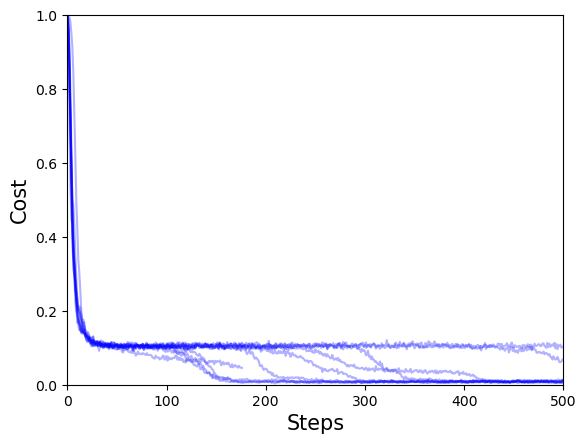

In [ ]:
for costs in pd.read_csv('cost_history_dekagram.csv').to_numpy():
    plt.plot(costs, color='blue', alpha=0.3)
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.ylim(0,1)
plt.xlim(0,500)
# plt.savefig('Dekagram.png')

In [ ]:
def fidelity(params):
    @qml.qnode(qml.device('default.qubit', wires=10))
    def dekagram(optimized_params):
        qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=range(10))
        return qml.state()
    
    dekagram_exact = np.zeros(2**10)
    for row in pd.read_csv('deka.csv').to_numpy():
        dekagram_exact[int(''.join(row[0].split(' ')),2)]=row[1]
    dekagram_exact = dekagram_exact/np.sqrt(np.dot(dekagram_exact, dekagram_exact))
    
    return np.abs(np.dot(dekagram(params), dekagram_exact))

In [ ]:
# for i, params in enumerate(params_all):
#     save_params(params[-1], 'params_last_dekagram/'+str(i)+'.csv')

In [ ]:
# for i, params in enumerate(params_all):
#     ind = np.argmin(costs_all[i])
#     save_params(params[ind], 'params_best_dekagram/'+str(i)+'.csv')

In [ ]:
fidelities_last = []
for i in range(10):
    params = load_params('params_last_dekagram/'+str(i)+'.csv')
    fidelities_last.append(fidelity(params))

print('Fidelities:')
print('Mean: ',np.mean(fidelities_last), 'std: ',np.std(fidelities_last))

Fidelities:
Mean:  0.9824837439694984 std:  0.01619234088469076


In [ ]:
fidelities_best = []
for i in range(10):
    params = load_params('params_best_dekagram/'+str(i)+'.csv')
    fidelities_best.append(fidelity(params))

print('Fidelities:')
print('Mean: ',np.mean(fidelities_best), 'std: ',np.std(fidelities_best))

Fidelities:
Mean:  0.9832846672125296 std:  0.01689824647967673


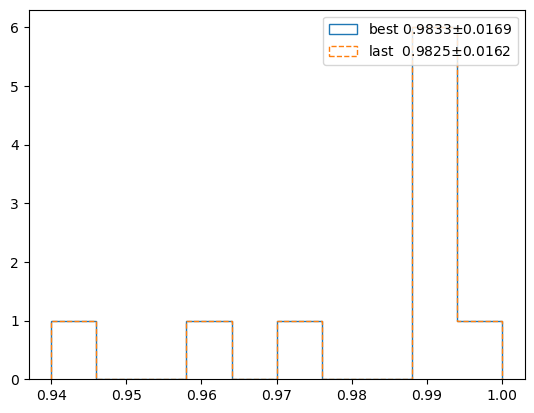

In [ ]:
plt.hist(fidelities_best, histtype='step', label='best '+f'{np.mean(fidelities_best):.4f}'+'$\pm$'+f'{np.std(fidelities_best):.4f}', range=(0.94,1))
plt.hist(fidelities_last, histtype='step', label='last  '+f'{np.mean(fidelities_last):.4f}'+'$\pm$'+f'{np.std(fidelities_last):.4f}', range=(0.94,1),linestyle='dashed')
plt.legend()
# plt.savefig('hist_dekagram.png')